# Particle filtering

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, t

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

np.set_printoptions(suppress=True, precision=4)

* Recursive Bayesian filtering by MC simulations

> They key idea is to represent the required posterior density function by a set of random samples with associated weights and to compute estimates based on these samples and weights

## Importance sampling

$$
\begin{aligned}
    \mathbb{E}[g(x) \vert {\bf y}] &\approx \frac{1}{N}\sum_{n=1}^N \frac{p(x^{(i)} \vert {\bf y})}{\pi(x^{(i)} \vert {\bf y})} g(x^{(i)} \vert {\bf y})\\
    &= \sum_{n=1}^N \tilde w^{(i)} g(x^{(i)} \vert {\bf y}),
\end{aligned}
$$

where 
$$
    \tilde w^{(i)} = \frac{p(x^{(i)} \vert {\bf y})}{N \pi(x^{(i)} \vert {\bf y})}
$$

In [3]:
# importance distribution
pi_dist = norm(0, 2)
# target distribution
p_dist = t(4, 0)

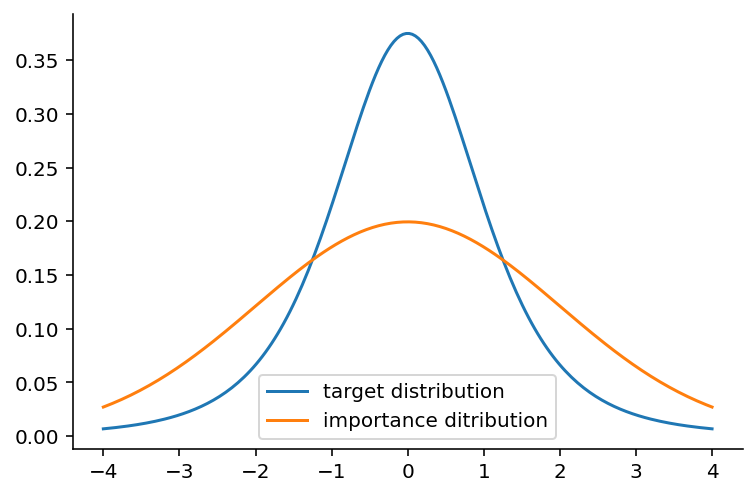

In [4]:
xrange = np.linspace(-4, 4, 200)
plt.plot(xrange, p_dist.pdf(xrange), label="target distribution")
plt.plot(xrange, pi_dist.pdf(xrange), label="importance ditribution")
plt.legend()

In [5]:
np.random.seed(314)
N = 100
# samples from the importance distribution
x_rvs = pi_dist.rvs(N)
# Samples from the target distribution
p_rvs = p_dist.rvs(N)

In [6]:
weights = p_dist.pdf(x_rvs) / (N * pi_dist.pdf(x_rvs))

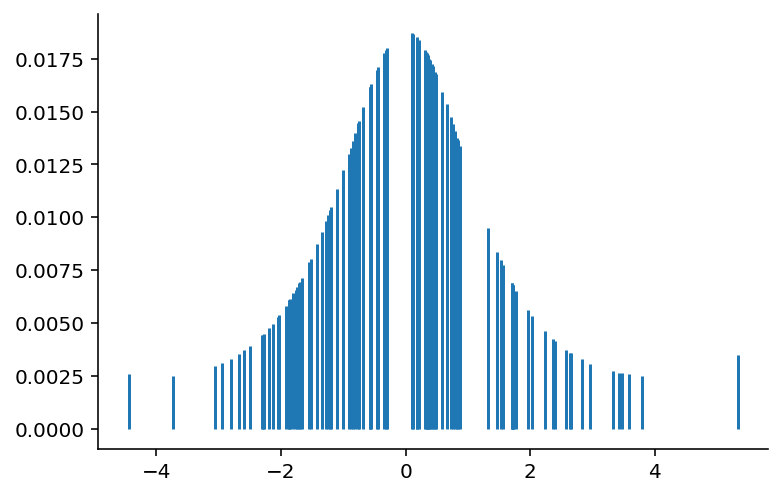

In [7]:
for xi, wi in zip(x_rvs, weights):
    plt.vlines(xi, 0, wi)

In [8]:
def g(x): return x ** 2

In [9]:
(weights * g(x_rvs)).sum()

1.6542189530195281

In [10]:
g(p_rvs).mean()

2.0109239264713437

> The disadvantage of direct importance sampling is that we should be able to evaluate $p(x^{(i)} \vert {\bf y})$ in order to use it directly.

That is, we need to compute
$$
    p(x^{(i)} \vert {\bf y}) = \frac{p(x^{(i)}) p({\bf y} \vert x^{(i)})}{\int p(x) p({\bf y} \vert x) dx},
$$

where the marginal likelihood may be difficult to compute.

## The Bootstrap filter

In [11]:
import jax
import jax.numpy as jnp
import nlds_lib as ds
from jax import random
from jax.scipy import stats
from jax.ops import index_update

1. Draw a new point ${\bf z}_t^{(n)}$ for each point in the sample set $\{{\bf z}_{t-1}^{(n)}\}_{n=1}^N$ from the model

$$
    {\bf z}_{t}^{(n)} \vert {\bf z}_{t-1}^{(n)} \sim p({\bf z}_t \vert {\bf z}_{t-1}^{(n)}) \ \forall n=1,\ldots,N
$$

2. Calculate the weights
$$
    w_{k}^{(n)} \propto p({\bf x}_t \vert {\bf z}_t^{(n)}) \forall n=1,\ldots,N,
$$
and normalize them to sum to unity

3. Do resampling

### Example

Suppose

$$
\begin{aligned}
    {\bf z}_t \vert {\bf z}_{t-1} &\sim \mathcal{N}(f_z({\bf z}_{t-1}), {\bf Q})\\
    {\bf x}_t \vert {\bf z}_{t} &\sim \mathcal{N}(f_x({\bf z}_{t}), {\bf R}) 
\end{aligned}
$$

In [12]:
def plot_samples(sample_state, sample_obs):
    fig, ax = plt.subplots()
    ax.plot(*sample_state.T, label="state space")
    ax.scatter(*sample_obs.T, s=60, c="tab:green", marker="+")
    ax.scatter(*sample_state[0], c="black", zorder=3)
    ax.legend()
    ax.set_title("Noisy observations from hidden trajectory")
    plt.axis("equal")

In [13]:
def fz(x, dt): return x + dt * jnp.array([jnp.sin(x[1]), jnp.cos(x[0])])
def fx(x): return x

In [14]:
dt = 0.4
nsteps = 100
# Initial state vector
x0 = jnp.array([1.5, 0.0])
# State noise
Qt = jnp.eye(2) * 0.001
# Observed noise
Rt = jnp.eye(2) * 0.05
alpha, beta, kappa = 1, 0, 2

key = random.PRNGKey(314)
model = ds.NLDS(lambda x: fz(x, dt), fx, Qt, Rt)
sample_state, sample_obs = model.sample(key, x0, nsteps)

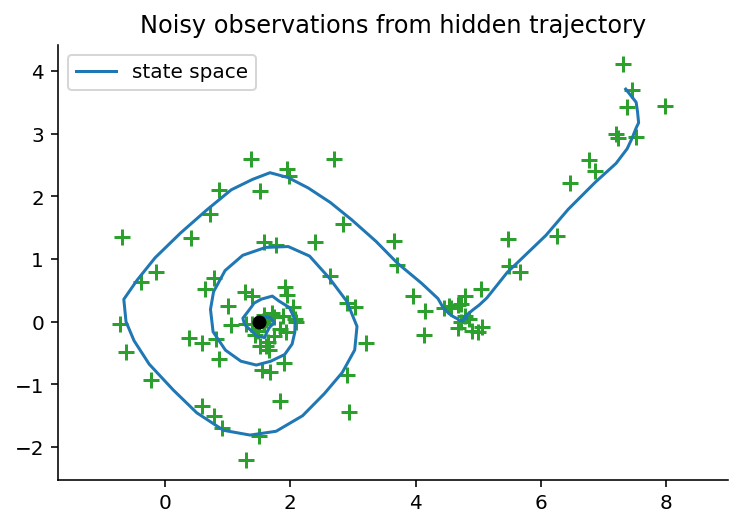

In [15]:
plot_samples(sample_state, sample_obs)

In [16]:
nsamples = 2000

#### First step

In [17]:
keys = random.split(key, nsteps)

zt_rvs = random.multivariate_normal(keys[0], x0, Qt, (nsamples,))
xt_rvs = random.multivariate_normal(keys[0], fx(zt_rvs), Rt)

In [18]:
weights_t = stats.multivariate_normal.pdf(sample_obs[0], xt_rvs, Qt)
weights_t = weights_t / weights_t.sum()
weights_t.sum()

DeviceArray(1., dtype=float32)

In [19]:
mu_t = (zt_rvs * weights_t[:, None]).sum(axis=0)
mu_t

DeviceArray([1.5   , 0.0004], dtype=float32)

#### Second step

In [20]:
fz_samples = jax.vmap(fz, in_axes=(0, None))

In [21]:
zt_rvs = random.multivariate_normal(keys[1], fz_samples(zt_rvs, dt), Qt)
xt_rvs = random.multivariate_normal(keys[1], fx(zt_rvs), Rt)

In [22]:
weights_t = stats.multivariate_normal.pdf(sample_obs[1], xt_rvs, Qt)
weights_t = weights_t / weights_t.sum()
weights_t.sum()

DeviceArray(1., dtype=float32)

In [23]:
mu_t = (zt_rvs * weights_t[:, None]).sum(axis=0)
mu_t

DeviceArray([ 1.5332, -0.0057], dtype=float32)

### All together

In [24]:
mu_hist = jnp.zeros((nsteps, 2))

for t, key_t in enumerate(keys):
    if t == 0:
        zt_rvs = random.multivariate_normal(key_t, x0, Qt, (nsamples,))
    else:
        zt_rvs = random.multivariate_normal(key_t, fz_samples(zt_rvs, dt), Qt)
        
    xt_rvs = random.multivariate_normal(key_t, fx(zt_rvs), Rt)
    
    weights_t = stats.multivariate_normal.pdf(sample_obs[t], xt_rvs, Qt)
    weights_t = weights_t / weights_t.sum()
    
    mu_t = (zt_rvs * weights_t[:, None]).sum(axis=0)
    mu_hist = index_update(mu_hist, t, mu_t)

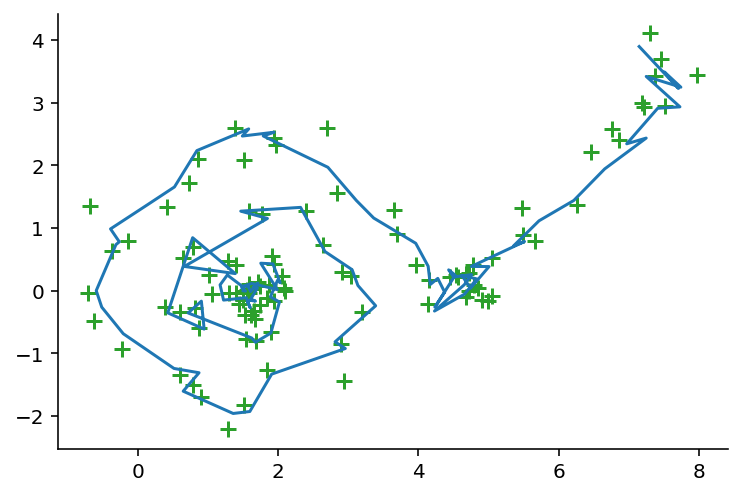

In [25]:
fig, ax = plt.subplots()
ax.plot(*mu_hist.T)
ax.scatter(*sample_obs.T, s=60, c="tab:green", marker="+")

## Rao-Blackwellized Particle Filtering (RBPF)

The RBPF considers the following system
$$
\begin{aligned}
    p({\bf z}_t \vert {\bf z}_{t-1}, {\bf u}_{t-1}) &= \mathcal{N}\big({\bf A}_t({\bf u}_{t-1}){\bf z}_{t-1}, {\bf Q}_t({\bf u}_{t-1})\big) \\
    p({\bf x}_t \vert {\bf z}_t, {\bf u}_t) &= \mathcal{N}\big({\bf H}_t({\bf u}_t) {\bf z}_t, {\bf R}_t({\bf u}_t)\big)\\
    p({\bf u}_t \vert {\bf u}_{t-1}) &= \texttt{(Any given distribution)}
\end{aligned}
$$

In [26]:
from functools import partial
from jax.scipy.special import logit

### An example: tracking a maneuvering object

In [27]:
B1 = jnp.array([0, 0, 0, 0])
B2 = jnp.array([-1.225, -0.35, 1.225, 0.35])
B3 = jnp.array([1.225, 0.35,  -1.225,  -0.35])

B_matrices = jnp.stack([B1, B2, B3], axis=0)

In [28]:
# Transition probabilities of the latent variables of the system 
transition_matrix = jnp.array([
    [0.9, 0.05, 0.05],
    [0.05, 0.9, 0.05],
    [0.05, 0.05, 0.9]
])

In [29]:
p_init = jnp.array([0, 1, 0.0])

In [30]:
Q = jnp.eye(4) * 0.8
R = jnp.eye(2) * 3
zeros = jnp.zeros(4)


TT = 0.1
A = jnp.array([[1, TT, 0, 0],
               [0, 1, 0, 0],
               [0, 0, 1, TT],
               [0, 0, 0, 1]])

C = jnp.array([[1, 0, 0, 0], [0, 1, 0, 0]])

In [31]:
def draw_state(val, key, transition_matrix, A, B, C, Q, R):
    """
    Simulate one step of a system that evolves as
                A z_{t-1} + Bk + eps,
    where eps ~ N(0, Q).
    
    Parameters
    ----------
    val: tuple
        (state of system, value of target)
    key: PRNGKey
    A: array()
    B: array(S, M, M)
    C: array
    Q: array
    R: array
    """
    current_state, latent_val = val
    probabilities = transition_matrix[current_state, :]
    logits = logit(probabilities)
    state = jax.random.categorical(key, logits)
    
    zeros_obs, zeros_state = C.shape
    zeros_obs = jnp.zeros(zeros_obs)
    zeros_state = jnp.zeros(zeros_state)
    
    latent_val = A @ latent_val + B[state, :] + random.multivariate_normal(key, zeros_state, Q)
    obs_val = C @ latent_val + random.multivariate_normal(key, zeros_obs, R)
    
    
    return (state, latent_val), (state, latent_val, obs_val)

nparticles = 500
nsteps = 200
key = random.PRNGKey(314159)
init_key, sample_key = random.split(key, 2)
keys = random.split(sample_key, nsteps-1)

draw_state_fixed = partial(draw_state,
                           transition_matrix=transition_matrix,
                           A=A, B=B_matrices, C=C, Q=Q, R=R)

init_state = 0
init_target = random.multivariate_normal(init_key, jnp.zeros(4), jnp.identity(4))
final_state, (states, target, sample_obs) = jax.lax.scan(draw_state_fixed, (init_state, init_target), keys)

# Append initial state and starting state (target) position
states = jnp.concatenate([jnp.asarray([init_state]), states])
target = jnp.concatenate([init_target[None, :], target])

In [32]:
(A @ target[10])[None, :]

DeviceArray([[-0.4962,  0.2958,  0.8353,  1.2424]], dtype=float32)

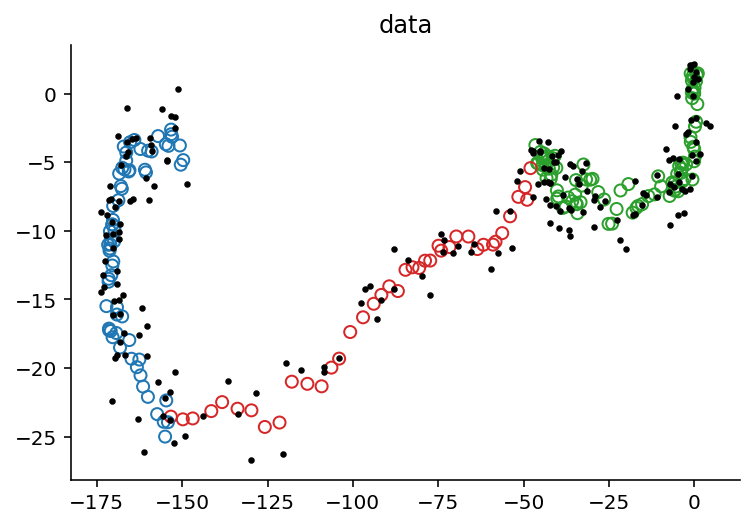

In [33]:
color_dict = {0: "tab:green", 1: "tab:red", 2: "tab:blue"}
color_states = [color_dict[state] for state in states]
plt.scatter(*target[:, :2].T, color="none", edgecolors=color_states)
plt.scatter(*sample_obs.T, s=5, c="black")
plt.title("data");

### Implementation

In [177]:
key_test = random.PRNGKey(1)

# Initial mean estimation
mu_t = 0.01 * random.normal(key, (4,))
Sigma_t = jnp.zeros((4,4))

p_step = jnp.array([0.05, 0.9, 0.05])
k = random.categorical(key, logit(p_step))

In [131]:
mu_t_cond = A @ mu_t + B_matrices[k]
Sigma_t_cond = A @ Sigma_t @ A.T + Q

xt_cond = C @ mu_t_cond
St =  C @ Sigma_t_cond @ C.T + R

In [132]:
I = jnp.eye(4)
Kt = Sigma_t_cond @ C.T @ jnp.linalg.inv(St)

# Estimation update
mu_t = mu_t_cond + Kt @ (sample_obs[0] - xt_cond)
Sigma_t  = (I - Kt @ C) @ Sigma_t_cond

In [133]:
mu_t

DeviceArray([-1.1946,  0.1034,  1.2037,  0.3488], dtype=float32)

In [150]:
from dataclasses import dataclass

@dataclass
class RBPFParams:
    A: jnp.array
    B: jnp.array
    C: jnp.array
    Q: jnp.array
    R: jnp.array
    transition_matrix: jnp.array
        
params = RBPFParams(A, B_matrices, C, Q, R, transition_matrix)

In [151]:
def kf_update(mu_t, Sigma_t, k, xt, params):
    I = jnp.eye(len(mu_t))
    mu_t_cond = params.A @ mu_t + params.B[k]
    Sigma_t_cond = params.A @ Sigma_t @ params.A.T + params.Q
    xt_cond = params.C @ mu_t_cond
    St = params.C @ Sigma_t_cond @ params.C.T + params.R
    
    Kt = Sigma_t_cond @ params.C.T @ jnp.linalg.inv(St)
    # Estimation update
    mu_t = mu_t_cond + Kt @ (xt - xt_cond)
    Sigma_t  = (I - Kt @ params.C) @ Sigma_t_cond
    
    return mu_t, Sigma_t

In [153]:
# Initial mean estimation
mu_t = 0.01 * random.normal(key, (4,))
Sigma_t = jnp.zeros((4,4))

params = RBPFParams(A, B_matrices, C, Q, R, transition_matrix)

kf_update(mu_t, Sigma_t, k, sample_obs[0], params)

(DeviceArray([-1.1946,  0.1034,  1.2037,  0.3488], dtype=float32),
 DeviceArray([[0.6316, 0.    , 0.    , 0.    ],
              [0.    , 0.6316, 0.    , 0.    ],
              [0.    , 0.    , 0.8   , 0.    ],
              [0.    , 0.    , 0.    , 0.8   ]], dtype=float32))

In [155]:
def rbpf_step(key, st, mu_t, Sigma_t, xt, params):
    log_p_next = logit(params.transition_matrix[st])
    k = random.categorical(key, log_p_next)
    mu_t, Sigma_t = kf_update(mu_t, Sigma_t, k, xt, params)
    return mu_t

In [181]:
key_test = random.PRNGKey(1)

# Initial mean estimation
mu_t = 0.01 * random.normal(key, (4,))
Sigma_t = jnp.zeros((4,4))

p_step = jnp.array([0.05, 0.9, 0.05])
st = random.categorical(key, logit(p_step))

In [182]:
key_sample = random.PRNGKey(1)
rbpf_step(key, st, mu_t, Sigma_t, sample_obs[0], params)

DeviceArray([-1.1946,  0.1034,  1.2037,  0.3488], dtype=float32)

In [183]:
# vectorised RBPF step
rbpf_step_vec = jax.vmap(rbpf_step, in_axes=(0, 0, 0, 0, None, None))

nparticles = 100
mu_t = 0.01 * random.normal(key, (nparticles, 4))
Sigma_t = jnp.zeros((nparticles, 4,4))
keys = random.split(key_sample, nparticles)
st = random.categorical(key, logit(p_step), shape=(nparticles,))

In [187]:
rbpf_step_vec(keys, st, mu_t, Sigma_t, sample_obs[0], params)

DeviceArray([[-1.2025,  0.1163,  1.217 ,  0.3624],
             [-1.1899,  0.111 ,  1.2244,  0.3461],
             [-1.2054,  0.0959,  1.2286,  0.359 ],
             [-1.1823,  0.097 ,  1.2207,  0.354 ],
             [-1.1876,  0.1064,  1.2317,  0.3643],
             [-0.2471,  0.3772, -0.0076,  0.004 ],
             [-1.1939,  0.0884,  1.2296,  0.3472],
             [-1.187 ,  0.097 ,  1.2242,  0.3598],
             [-1.1921,  0.1104,  1.2084,  0.3553],
             [-1.2003,  0.1006,  1.2187,  0.3345],
             [-1.2092,  0.1015,  1.221 ,  0.3303],
             [-1.1939,  0.0926,  1.2369,  0.3511],
             [-1.2013,  0.1031,  1.2206,  0.3414],
             [-1.1985,  0.104 ,  1.2277,  0.337 ],
             [-1.2113,  0.0904,  1.2303,  0.3406],
             [-1.1934,  0.1037,  1.229 ,  0.3611],
             [-1.19  ,  0.0999,  1.2275,  0.3341],
             [-1.2046,  0.1081,  1.225 ,  0.3608],
             [-1.2013,  0.1181,  1.2443,  0.3496],
             [-1.1997,  0.0961,

## References
1. Bayesian Filtering and Smoothing - Simo Särkkä
2. RBPF implementation by K. Murphy ([code](https://github.com/probml/pmtk3/blob/master/demos/rbpfManeuverDemo.m))